#### includes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import mlflow
import pytorch_lightning as pl
from pytorch_lightning.utilities.cloud_io import load as pl_load
import torch
import sys

plt.rcParams["figure.figsize"] = (18, 5)

In [3]:
import sources
from steered_cnn.utils.rotequivariance_toolbox import *
from steered_cnn.steered_conv.steerable_filters import radial_steerable_filter, plot_filter
from steered_cnn.utils.clip_pad import clip_pad_center
from steered_cnn.steered_conv import SteerableKernelBase
from src.trainer import BinaryClassifierNet
from sources import load_dataset, parse_config, setup_model

### Cos Sin Combination Test

In [4]:
alpha = torch.linspace(0, 2*np.pi, 4)
k_max = 5
kalpha = torch.stack([k*alpha for k in range(1,k_max+1)])
true_cos_sin_kalpha = torch.stack([torch.cos(kalpha), torch.sin(kalpha)])

In [17]:
from steered_cnn.steered_conv.steerable_filters import cos_sin_ka, cos_sin_ka_stack
fast_cos_sin_kalpha = cos_sin_ka_stack(torch.cos(alpha), torch.sin(alpha), k_max)
diff = true_cos_sin_kalpha-fast_cos_sin_kalpha
print('Average Diff:')
pd.DataFrame({'diff cos':diff[0].mean(-1), 'diff sin': diff[0].mean(-1), 'cos':fast_cos_sin_kalpha[0,:,1], 'sin': fast_cos_sin_kalpha[1,:,1]}, index=list(range(1,k_max+1)))

Average Diff:


,diff cos,diff sin,cos,sin
1,0.000000e+00,0.000000e+00,-0.5,8.660254e-01
2,-7.450581e-09,-7.450581e-09,-0.5,-8.660255e-01
3,1.490116e-08,1.490116e-08,1.0,1.788139e-07
4,2.235174e-08,2.235174e-08,-0.5,8.660253e-01
5,5.960464e-08,5.960464e-08,-0.5,-8.660256e-01


**Not Unary cos sin**

In [22]:
fast_cos_sin_kalpha = cos_sin_ka_stack(torch.cos(alpha)*3, torch.sin(alpha)*3, k_max)
diff = true_cos_sin_kalpha*3-fast_cos_sin_kalpha
print('Average Diff:')
pd.DataFrame({'diff cos':diff[0].mean(-1), 'diff sin': diff[0].mean(-1), 'cos':fast_cos_sin_kalpha[0,:,1], 'sin': fast_cos_sin_kalpha[1,:,1]}, index=list(range(1,k_max+1)))

Average Diff:


,diff cos,diff sin,cos,sin
1,0.000000e+00,0.000000e+00,-1.500000,2.598076e+00
2,-5.960464e-08,-5.960464e-08,-1.500000,-2.598077e+00
3,0.000000e+00,0.000000e+00,3.000000,7.152557e-07
4,1.788139e-07,1.788139e-07,-1.500001,2.598076e+00
5,1.192093e-07,1.192093e-07,-1.499999,-2.598077e+00


### Steerable Test

In [7]:
base = SteerableKernelBase.from_steerable(4)
x = torch.linspace(-2,2,5)
x,y = torch.meshgrid(x,x)
K = x+y
K = K.reshape(1,1,5,5)
K = clip_pad_center(K, base.base.shape)

info = {}

W = base.approximate_weights(K, info)
print(f'mse:{info["mse"]:.3f}, r2:{info["r2"]:.3f}')

torch.set_printoptions(precision=3, sci_mode=False)
print(W)


mse:0.027, r2:0.987
tensor([[[     0.000,     -0.000,      0.000,     -0.000,      0.579,
               3.625,      2.958,     -0.000,      0.000,     -0.000,
               0.594,     -1.866,      0.000,      0.000,      0.245,
              -1.820,      0.000,      0.514,     -0.000,      0.579,
               3.625,      2.958,     -0.000,      0.000,     -0.000,
              -0.594,      1.866,      0.000,     -0.000,      0.245,
              -1.820,     -0.000,     -0.514,      0.000]]])


**Checking weight approximation**

/home/gaby/These/src/SteeredCNN/3-git/lib/steered_cnn/steered_conv/steerable_filters.py:80: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


mse:0.027, r2:0.987


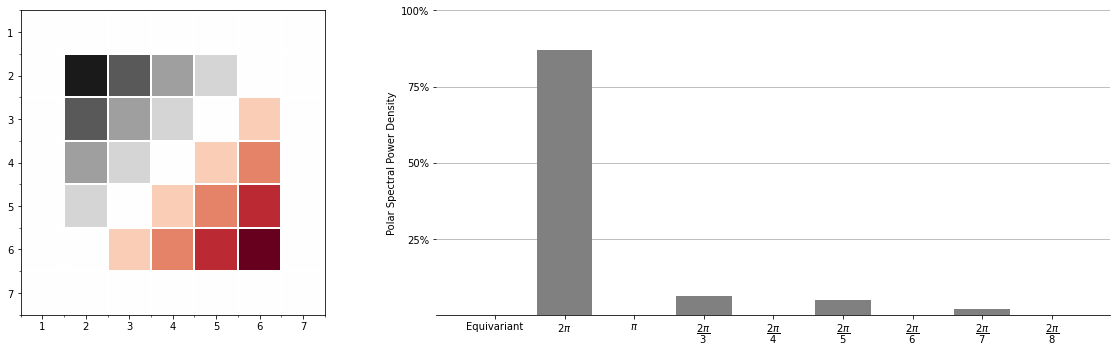

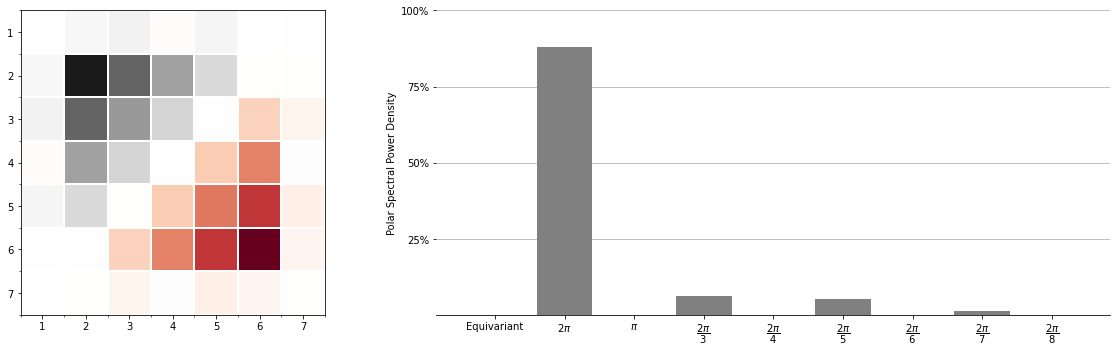

In [8]:
plot_filter(K[0,0], spd=True)
plot_filter(info['y_approx'][0,0], spd=True)
print(f'mse:{info["mse"]:.3f}, r2:{info["r2"]:.3f}')


**Checking filter rotation for different steer angle $\alpha$**

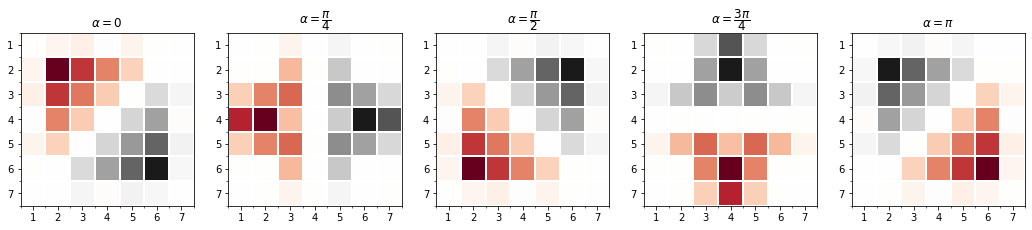

In [39]:
I = torch.zeros((1,1,7,7))
I[:,:,3,3] = 1
fig, axs = plt.subplots(1,5)
N = len(axs)-1
alphas = np.linspace(0, np.pi, N+1, endpoint=True)
for i in range(N+1):
    plot_filter(base.conv2d(I,W, alpha=alphas[i])[0,0], plot=axs[i])
    axs[i].set_title(f'$\\alpha = {repr_pi_fraction(i,N)}$')

**Resampling Artefact on Diamond**

/home/gaby/These/src/SteeredCNN/3-git/lib/steered_cnn/utils/rotequivariance_toolbox.py:79: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


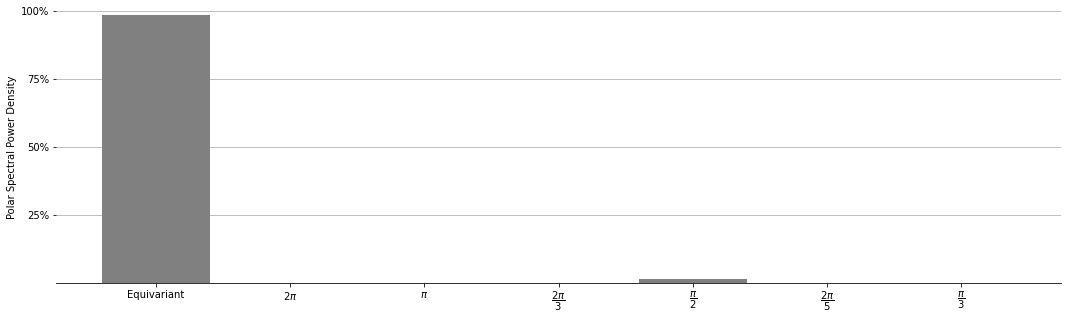

In [40]:
N = 12
alphas = -np.linspace(0, 2*np.pi, N, endpoint=False)
rotated_I = unrotate(torch.stack([base.conv2d(I,W, alpha=alphas[i])[0] for i in range(N)]).detach().numpy())
_ = spectral_power(rotated_I,plot=True)

**Resampling Artefact on Noise**

In [129]:
THETA = 12
thetas = np.linspace(0, 360, THETA, endpoint=False)
alphas = -torch.from_numpy(thetas)[:,None,None,None].float()*np.pi/180
cos_sin_alphas = torch.stack((torch.cos(alphas), torch.sin(alphas)))

I_n = clip_pad_center(torch.from_numpy(rotate(np.random.rand(3,120,120), thetas[1:])).float(), (256,256))

Spe0 min=0.5643970966339111, mean=0.8332486152648926, std=0.12507712841033936


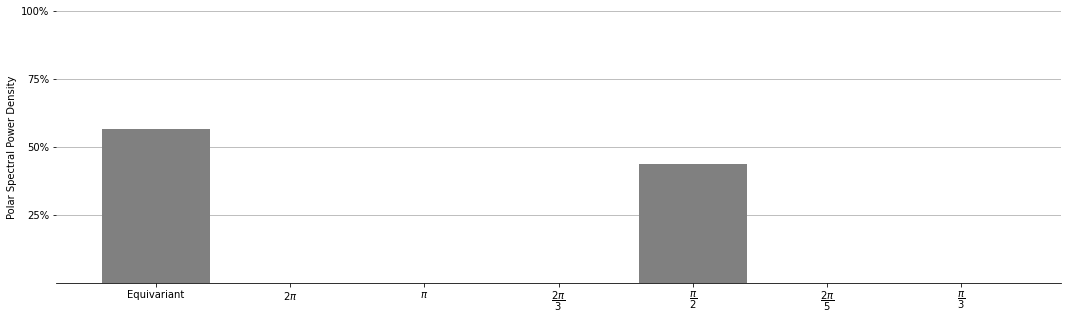

In [130]:
min_spe0 = 10
spe0 = []
for i in range(50):
    W_n = base.create_weights(3,1)
    y_n = torch.relu(base.conv2d(I_n,W_n, alpha=cos_sin_alphas, padding='true')).detach().numpy()
    rotated_I = unrotate(y_n, thetas[1:])
    spe = spectral_power(rotated_I)
    _spe0 = spe[0] / spe[:THETA//2].sum()
    spe0 += [_spe0]
    if min_spe0 > _spe0:
        min_spe0 = _spe0
        min_rotated_I = rotated_I
print(f'Spe0 min={min_spe0}, mean={np.mean(spe0)}, std={np.std(spe0)}')
_ = spectral_power(min_rotated_I, plot=True)

## Steerable Filters

34


/home/gaby/These/src/SteeredCNN/3-git/lib/steered_cnn/steered_conv/steerable_filters.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax_filt, ax_spd) = plt.subplots(1, 2)


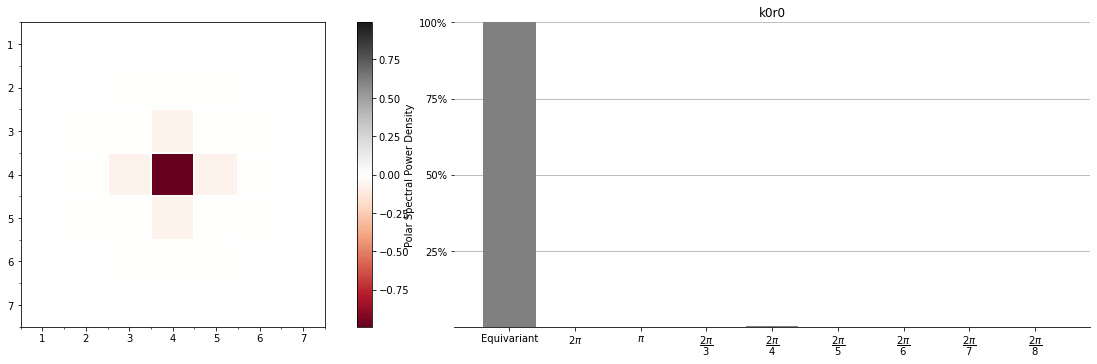

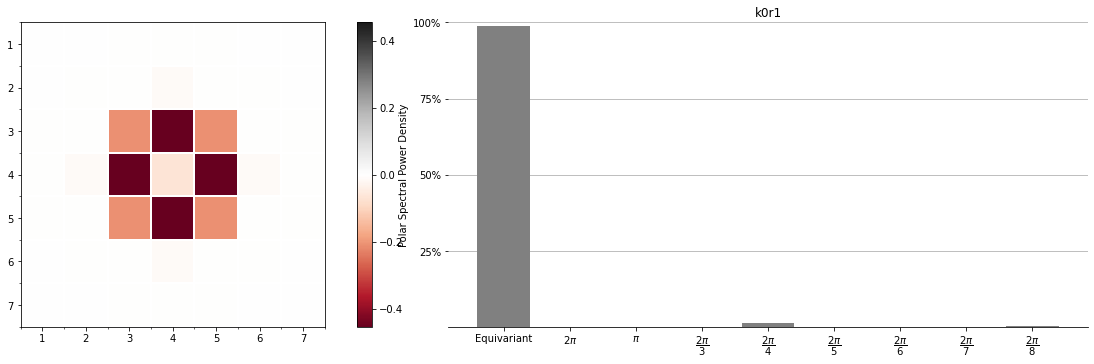

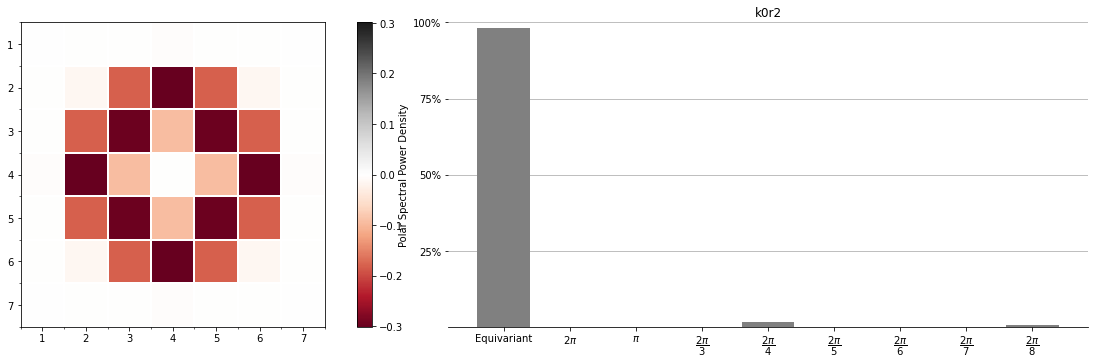

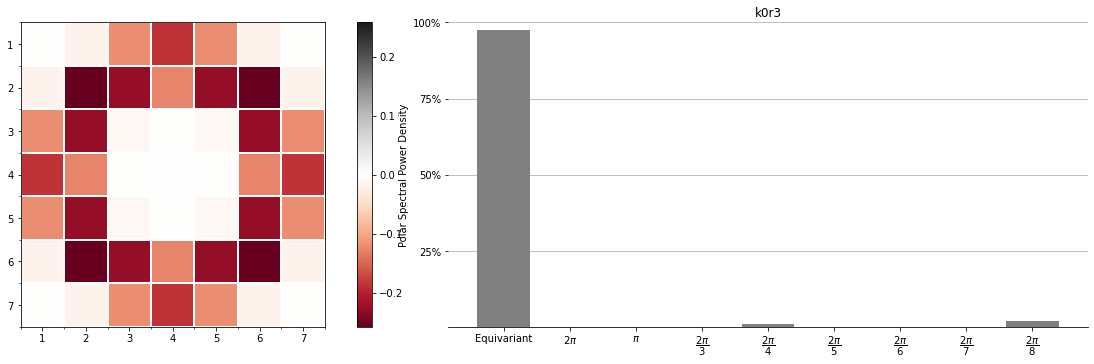

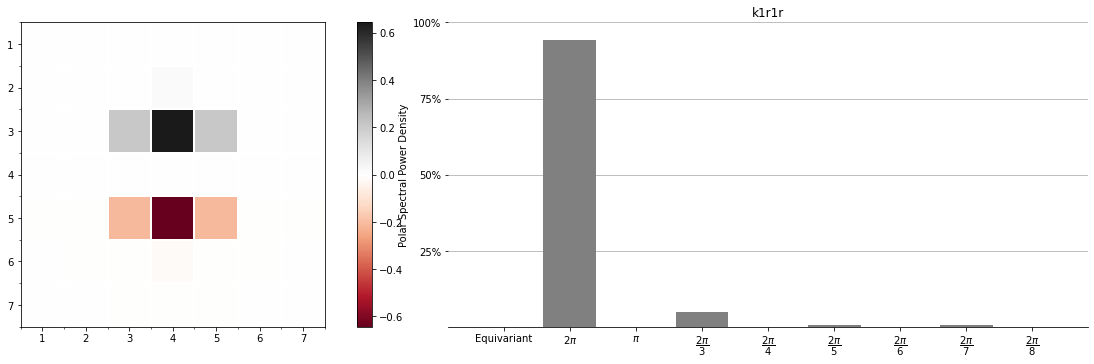

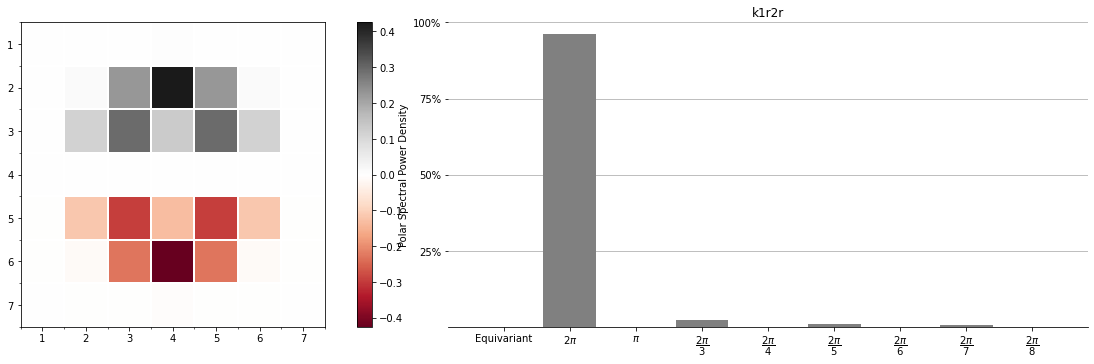

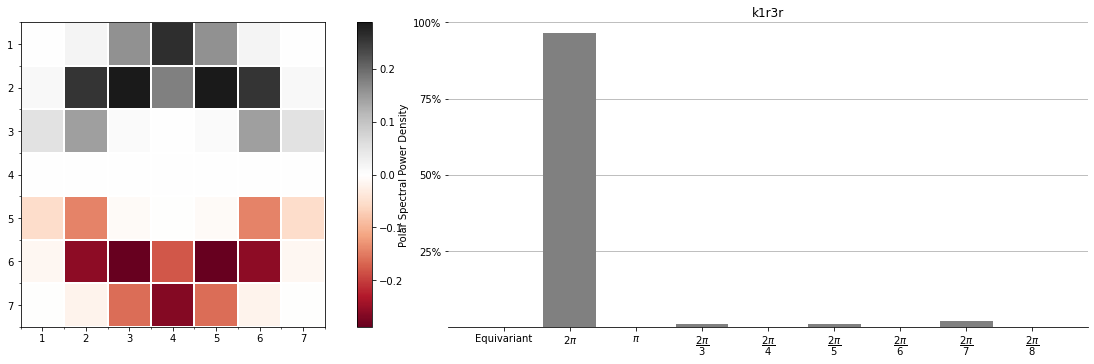

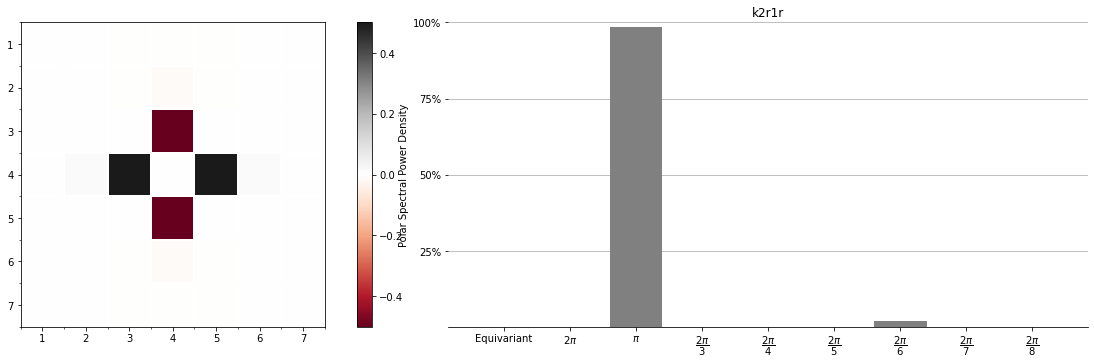

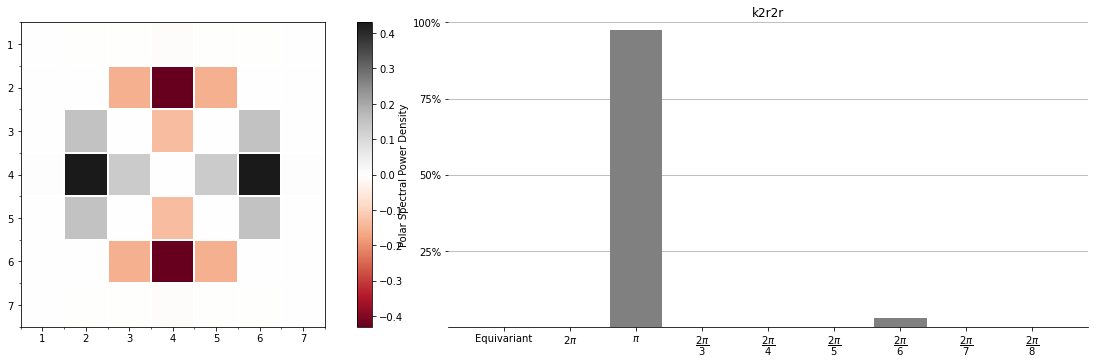

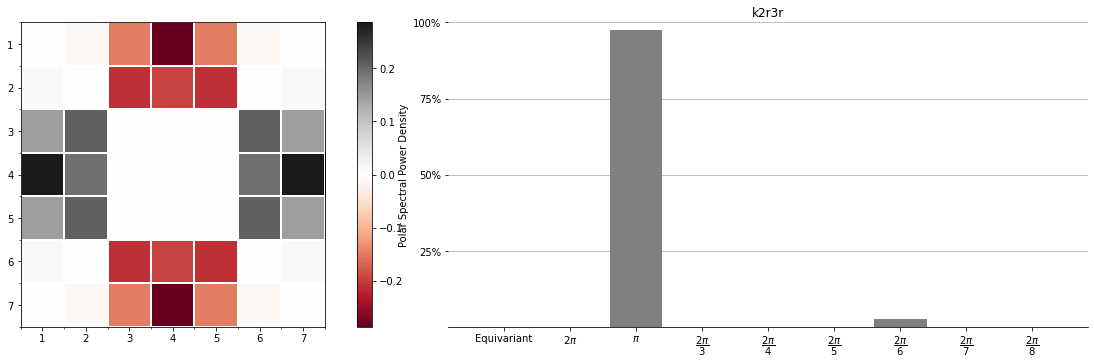

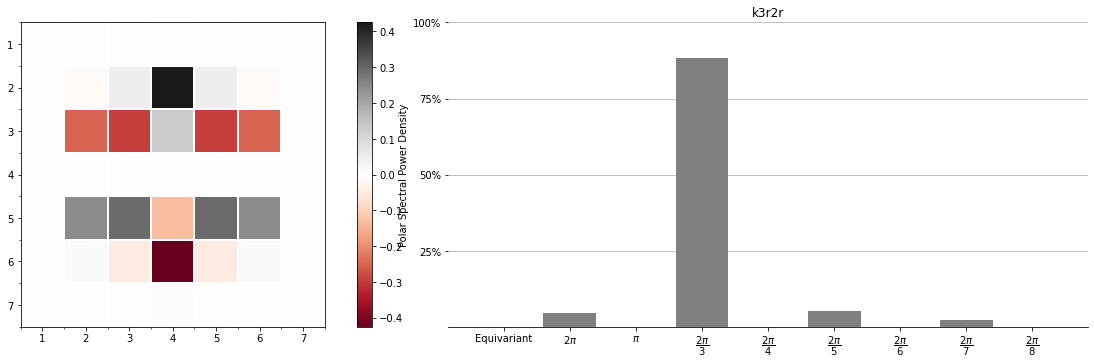

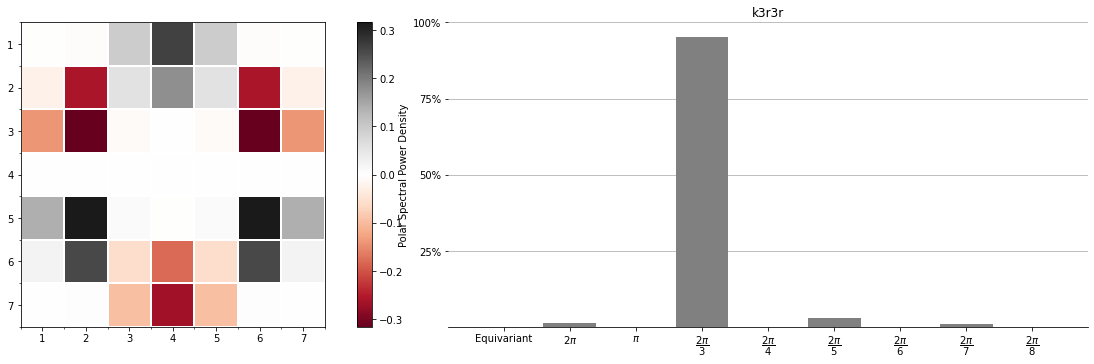

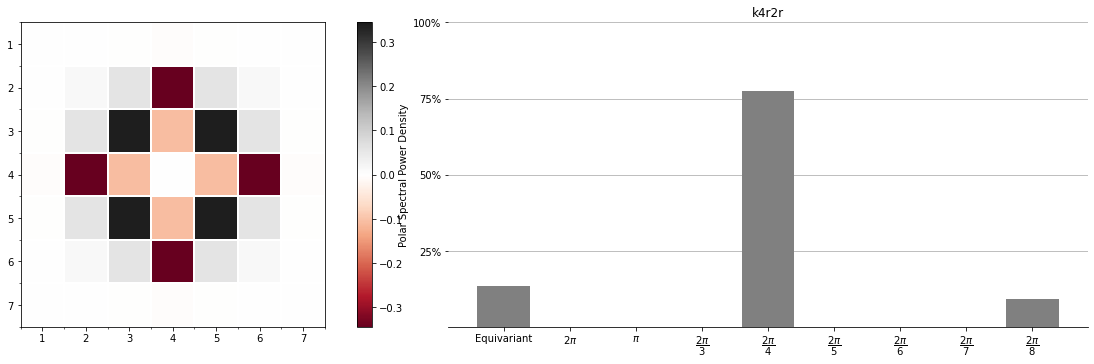

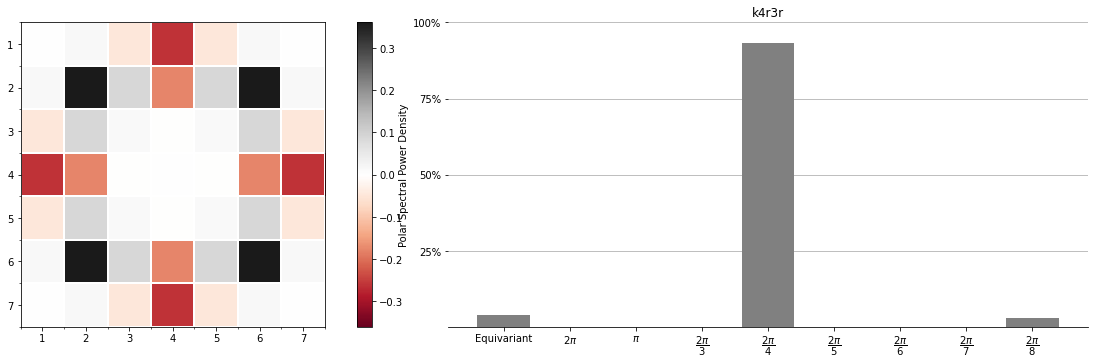

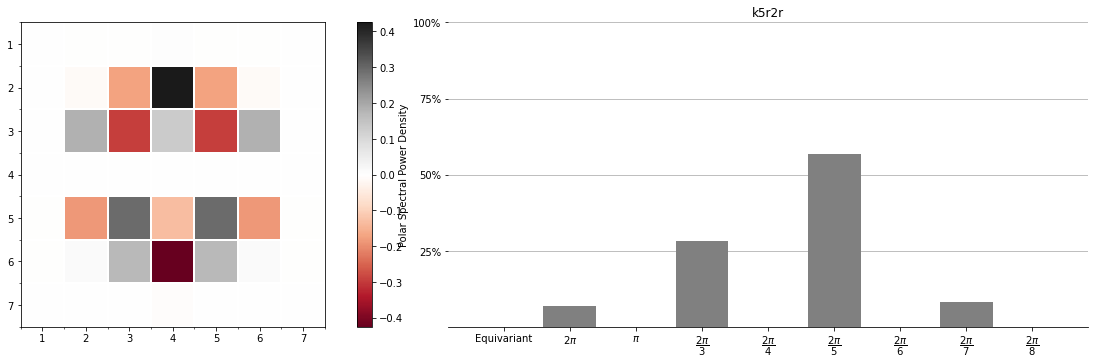

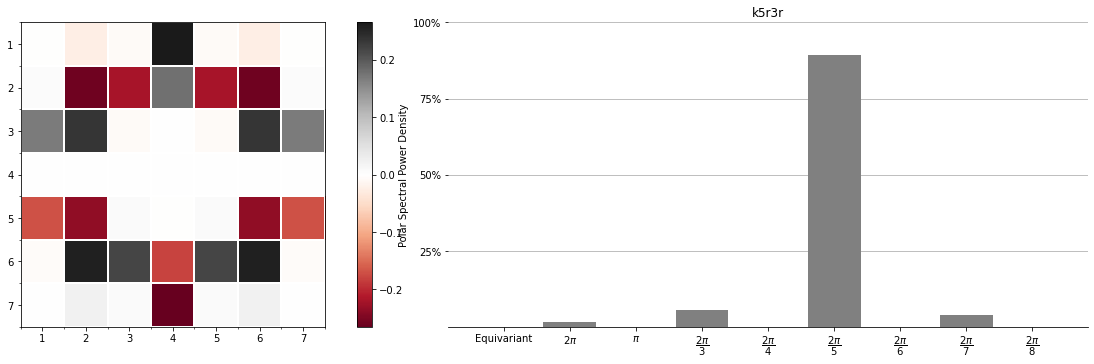

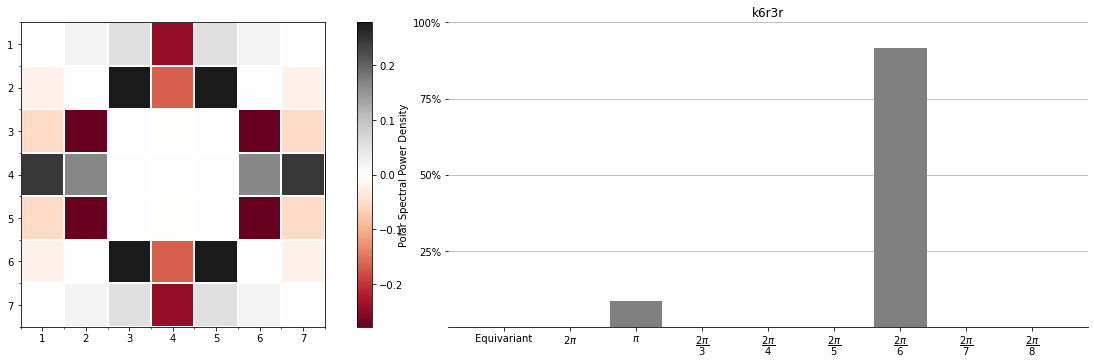

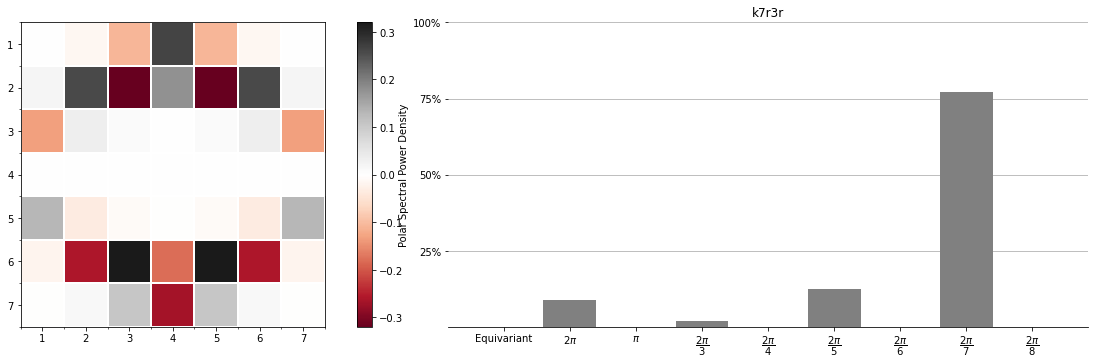

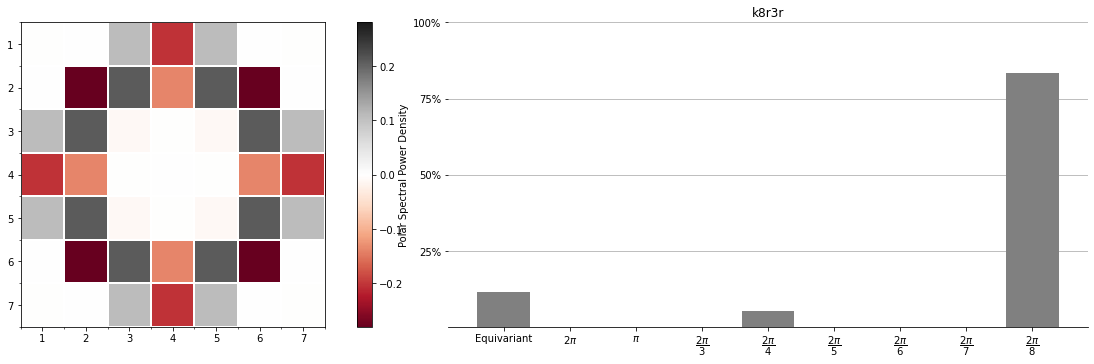

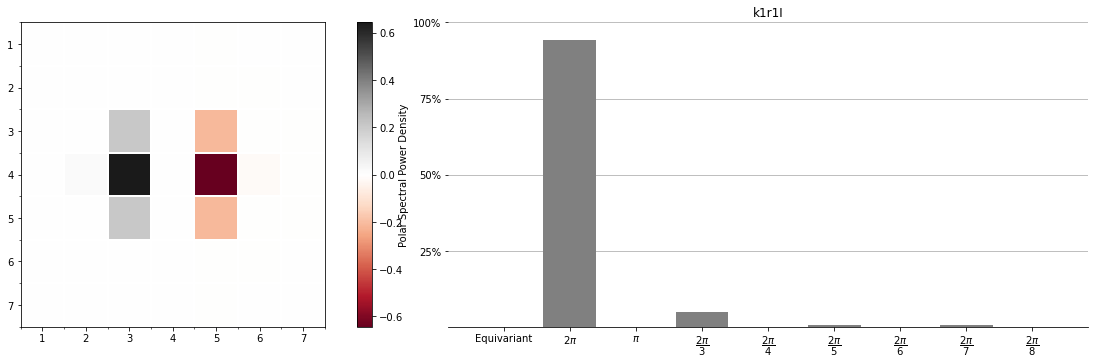

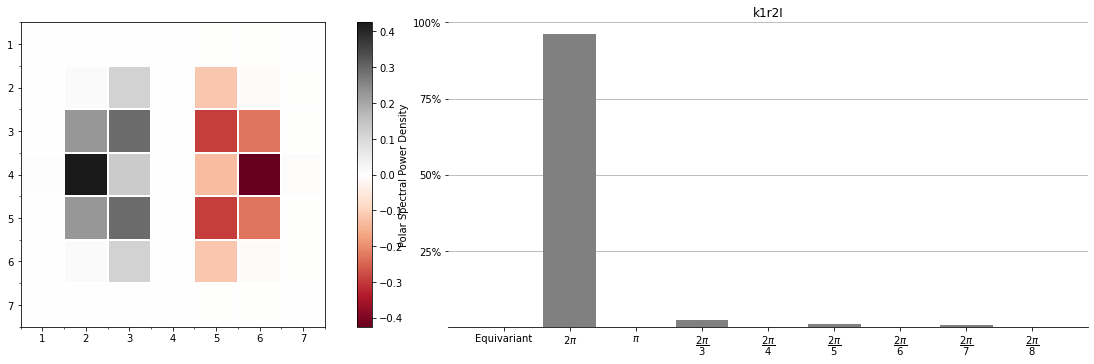

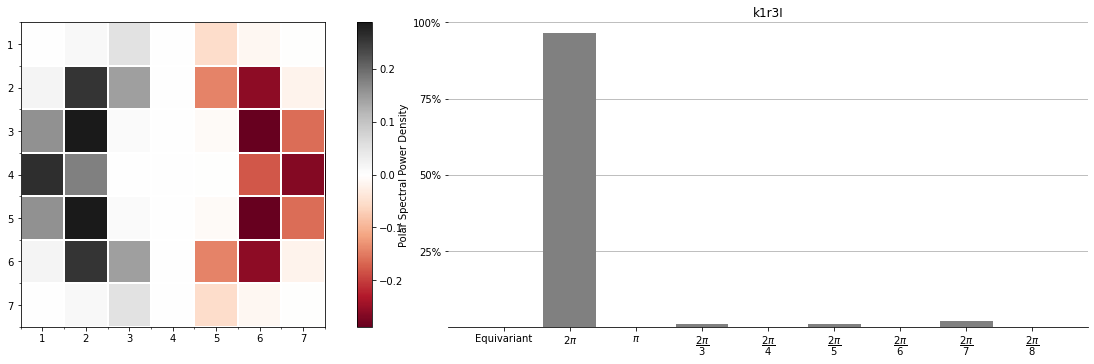

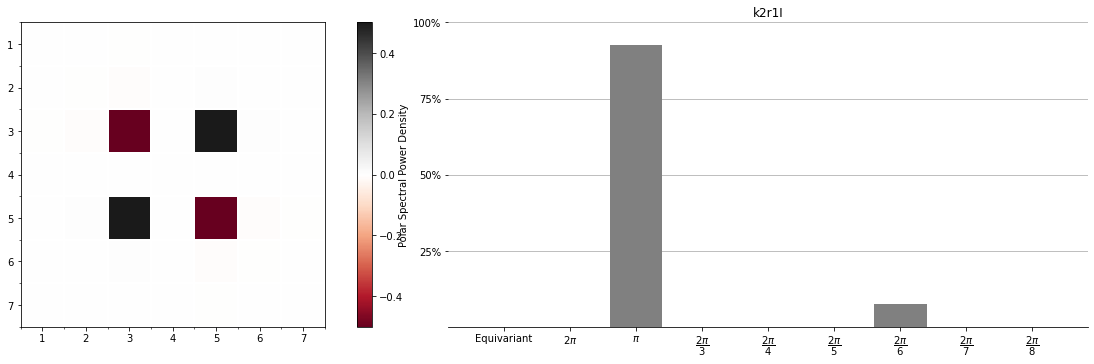

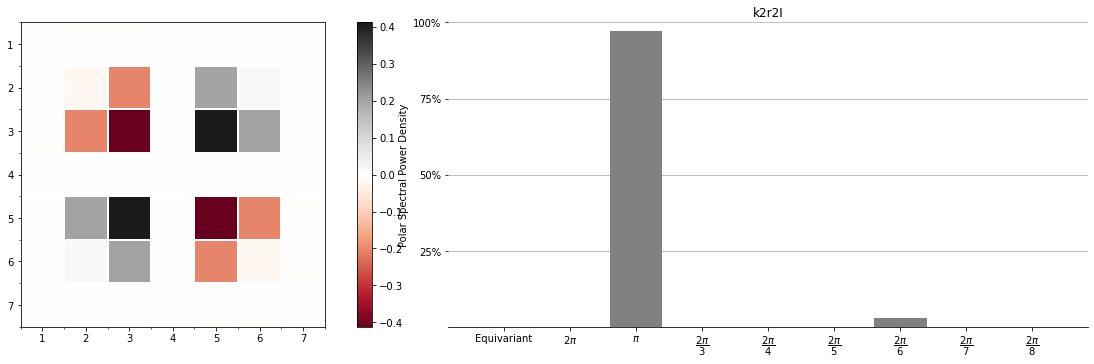

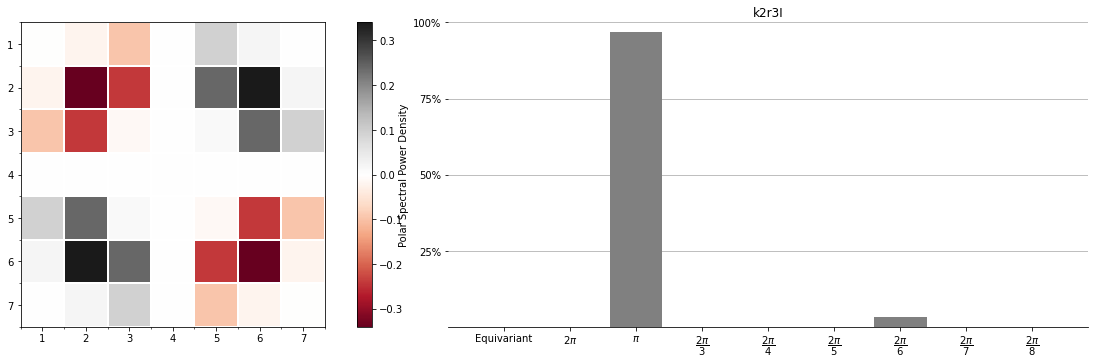

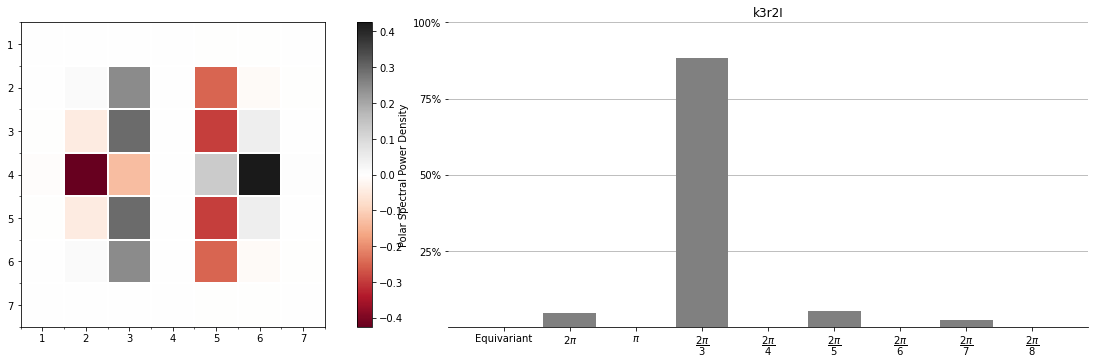

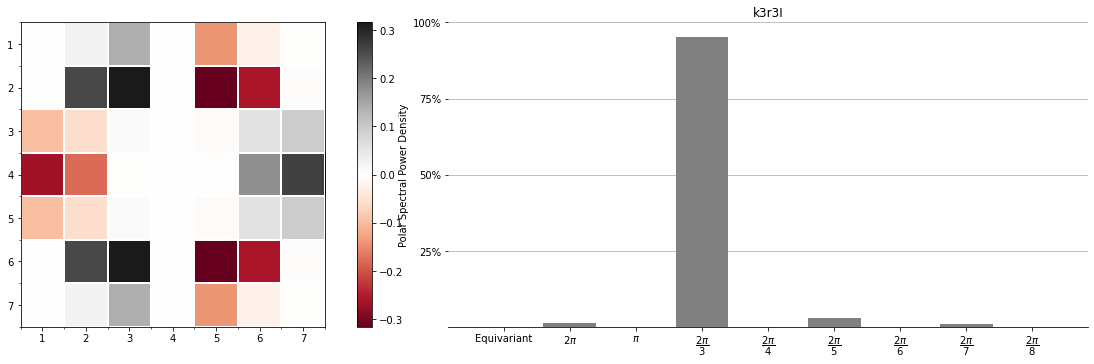

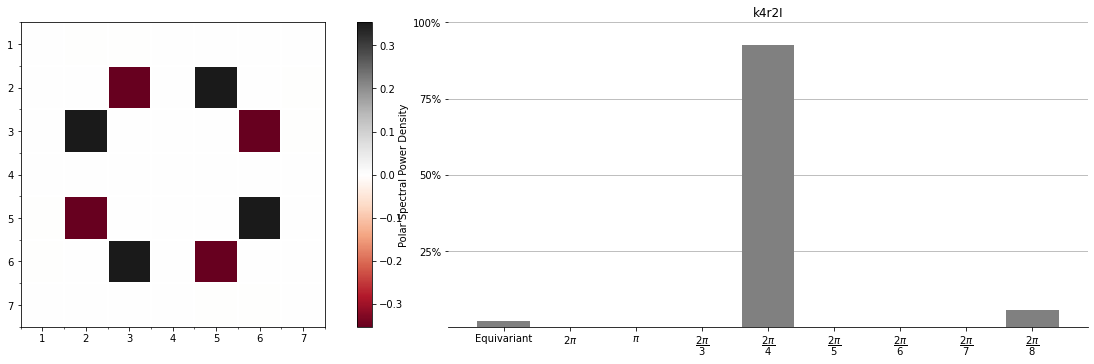

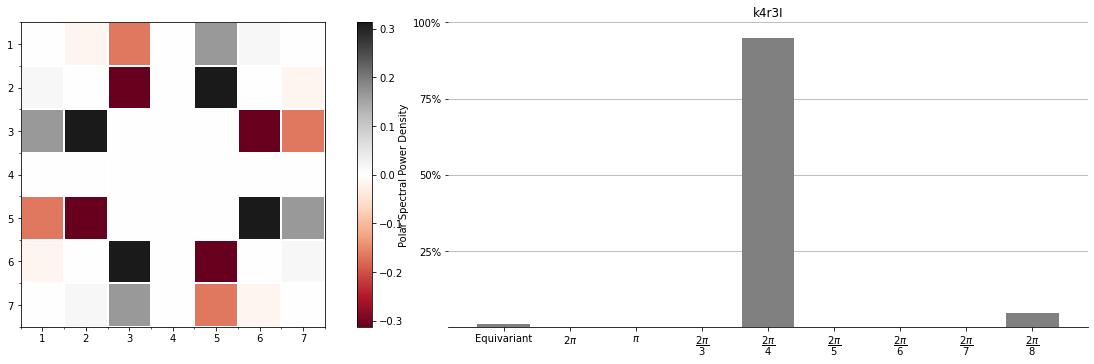

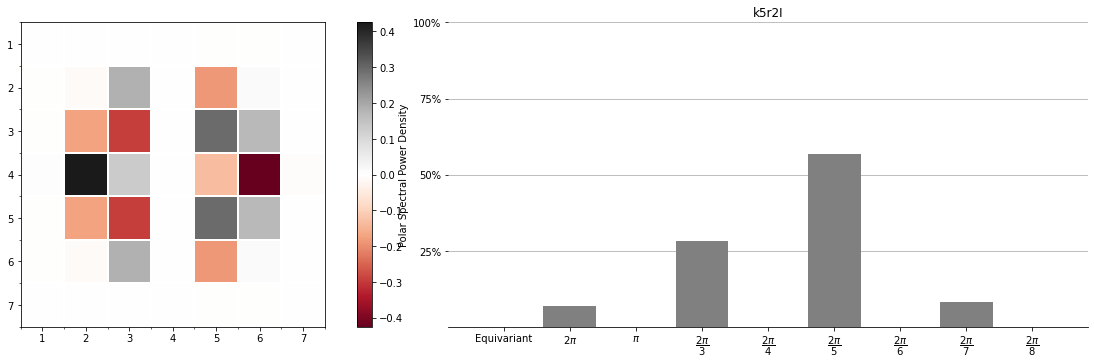

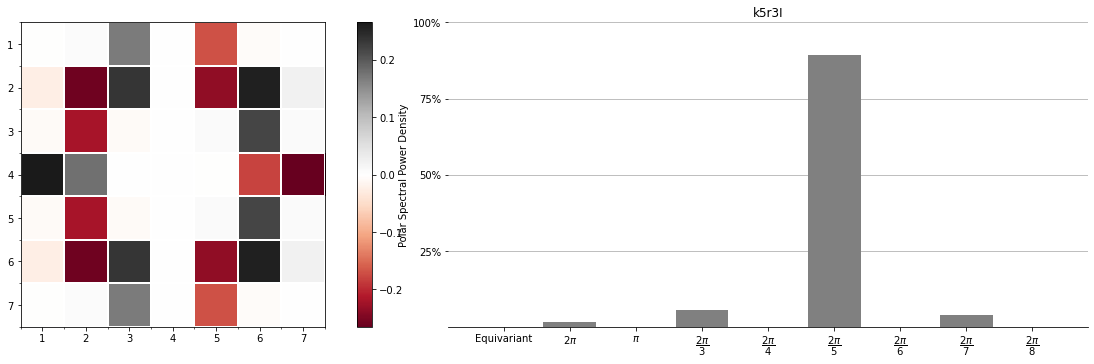

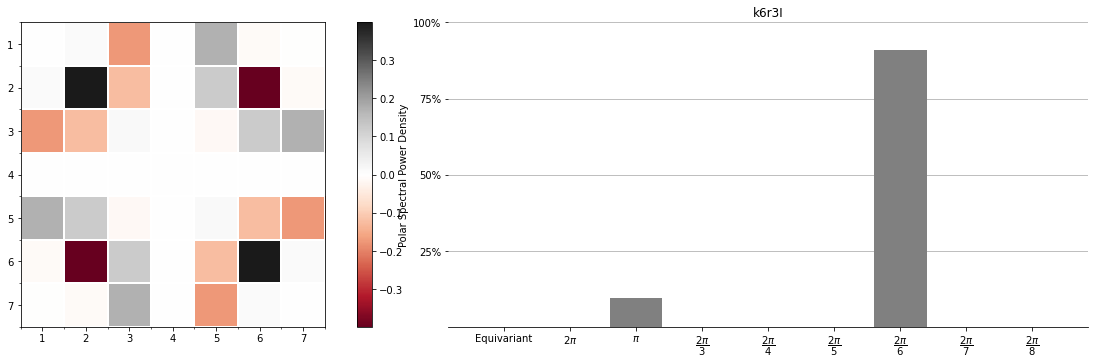

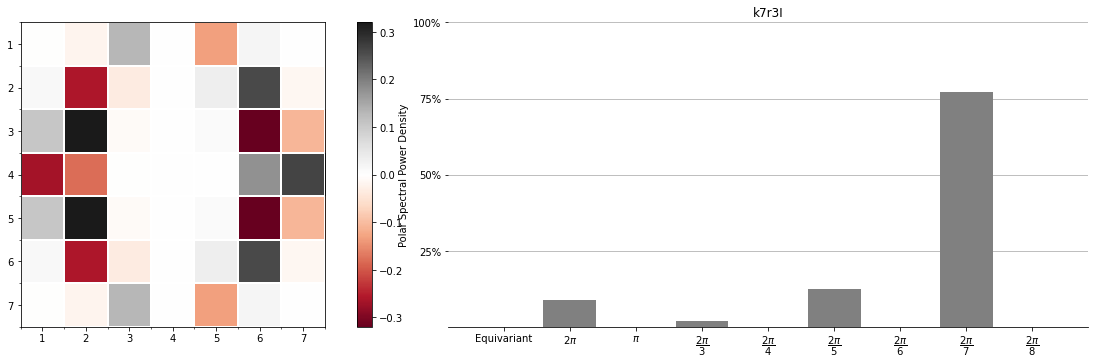

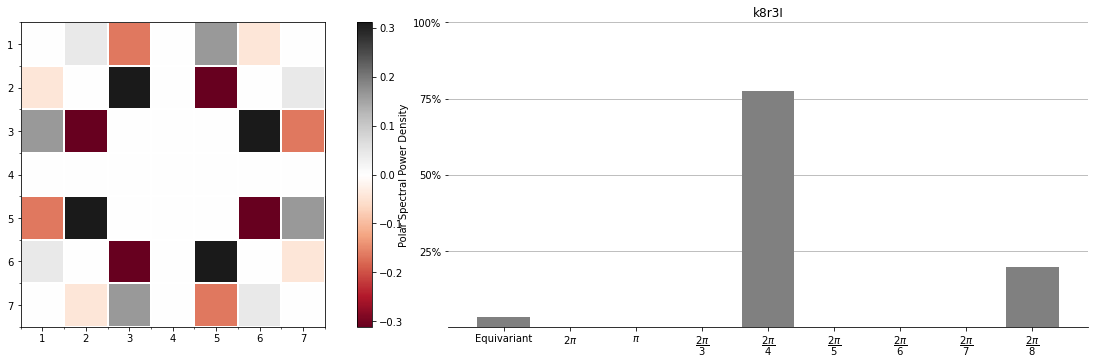

In [11]:
base = SteerableKernelBase.from_steerable(4)
for i, k_label in enumerate(base.kernels_label):
    plot_filter(base.base[i], spd=16, colorbar=True)
    plt.title(k_label)

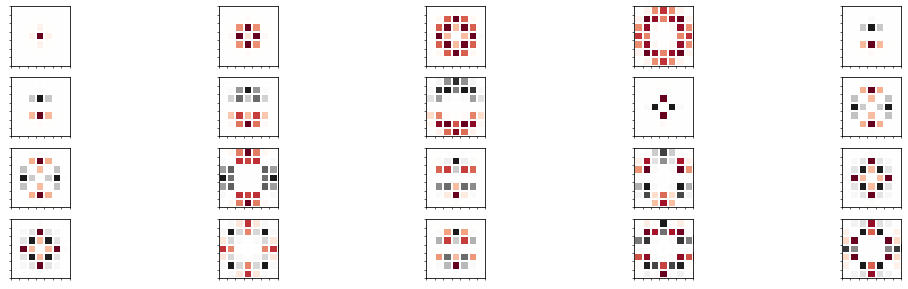

In [12]:
I = torch.zeros((1,1,7,7))
I[:,:,3,3] = 1
fig, axs = plt.subplots(4,5)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        plot_filter(base.base[i*4+j], plot=axs[i][j], axis=False)